# Прогнозирование ухода клиентов банка

## Задача <a class = "tocSkip">

Построить для банка модель, которая будет прогнозировать уход клиентов.

Модель должна демонстировать качество прогноза `F1` не ниже `0.59`. Дополнительная метрика — `AUC-ROC`.

## Предоставленные данные <a class = "tocSkip">

Исторические данные о поведении клиентов и расторжении договоров с банком.

Согласно описанию к данным:

- `Age` — возраст;
- `Balance` — баланс на счёте;
- `CreditScore` — кредитный рейтинг;
- `CustomerId` — уникальный идентификатор клиента;
- `EstimatedSalary` — предполагаемая зарплата;
- `Exited` — факт ухода клиента (**целевой признак**);
- `Geography` — страна проживания;
- `Gender` — пол;
- `HasCrCard` — наличие кредитной карты;
- `IsActiveMember` — активность клиента;
- `NumOfProducts` — количество продуктов банка, используемых клиентом;
- `RowNumber` — индекс строки в данных;
- `Surname` — фамилия;
- `Tenure` — сколько лет человек является клиентом банка.

## План работы <a class = "tocSkip">

Работа будет включать пять этапов:

1. загрузка и изучение данных;
2. подготовка данных;
3. исследование баланса классов; 
4. улучшение качества модели;
5. финальное тестирование лучшей модели.

##  Загрузка и изучение данных

In [1]:
# импортирование библиотек
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# отключение предупреждений
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# установления стиля графиков
sns.set_style("whitegrid")

Прочитаем файл с данными и изучим 5 случайных объектов, а также общую информацию о наборе данных:

In [2]:
# чтение файла с данными
data = pd.read_csv('/datasets/Churn.csv')

# вывод на экран пяти случайных строк
display(data.sample(5))
print()

# вывод на экран общей информации о наборе данных
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5829,5830,15794266,Cross,559,France,Male,32,9.0,145303.52,1,1,0,103560.98,0
1675,1676,15658459,Bates,784,Spain,Male,33,10.0,0.00,2,1,0,162022.47,0
2241,2242,15633112,Madukaego,681,Germany,Male,42,3.0,118199.97,2,1,0,9452.88,1
5409,5410,15690939,Howe,575,Spain,Male,28,7.0,0.00,1,1,1,10666.05,0
8916,8917,15665378,Shen,499,France,Female,46,6.0,0.00,2,1,0,73457.55,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Дополнительно изучим по каждому признаку:
- долю пропусков;
- количество уникальных значений;
- описательную статистику (для количественных признаков);
- уникальные значения (для категориальных признаков).

Также проверим наличие явных дубликатов.

In [3]:
# вывод на экран доли пропусков в каждом столбце
print('Доля пропусков')
print()
print(data.isna().mean() * 100)
print('-' * 80)
print()

# вывод на экран количества уникальных значений каждого столбца
print('Количество уникальных значений')
print()
print(data.nunique())
print('-' * 80)
print()

# вывод на экран описательной статистики для количественных признаков
print('Распределение значений количественных признаков')
display(data[['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance']].describe())
print('-' * 80)
print()

# вывод на экран уникальных значений для категориальных признаков
print('Уникальные значения категориальных признаков')
print()
for column in 'Surname', 'Geography', 'Gender':
    print(f'{column}: {data[column].sort_values().unique()}')
print('-' * 80)
print()

# вывод на экран количества дубликатов
print('Количество дубилкатов:', data.duplicated().sum())

Доля пропусков

RowNumber          0.00
CustomerId         0.00
Surname            0.00
CreditScore        0.00
Geography          0.00
Gender             0.00
Age                0.00
Tenure             9.09
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64
--------------------------------------------------------------------------------

Количество уникальных значений

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64
--------------------------------------------------------------------------------

Распределение значений количественных признаков


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000


--------------------------------------------------------------------------------

Уникальные значения категориальных признаков

Surname: ['Abazu' 'Abbie' 'Abbott' ... 'Zuev' 'Zuyev' 'Zuyeva']
Geography: ['France' 'Germany' 'Spain']
Gender: ['Female' 'Male']
--------------------------------------------------------------------------------

Количество дубилкатов: 0


### Выводы

По результатам изучения данных мы пришли к следующим выводам:

- в наборе данных 10 000 объектов;
- каждый объект в наборе данных — это информация о поведении одного клиента;
- по каждому объекту доступно 15 признаков (включая целевой);
- признаки *RowNumber*, *CustomerId* и *Surname* не требуются для построения модели;
- аномалии не выявлены;
- в столбце с признаком *Tenure* есть пропуски (9,09% данных).

На следующем этапе устраним выявленные пропуски и подготовим данные для обучения моделей.

## Подготовка данных

В ходе подготовки данных мы:
- удалим лишние признаки;
- устраним выявленные пропуски в столбце *Tenure*; 
- преобразуем категориальные признаки в численные;
- сохраним признаки и целевой признак в отдельные переменные; 
- разделим выборку на обучающую, валидационную и тестовую;
- масштабируем количественные признаки.

### Удаление лишних признаков

Удалим признаки *RowNumber*, *CustomerId* и *Surname*, не требуемые для построения модели:

In [4]:
# удаление признаков RowNumber, CustomerId и Surname, не требуемых для построения подели
data_useful = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# проверка удаления признаков
data_useful.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Устранение пропусков в столбце *Tenure*

Изучим объекты, содержащие пропуски:

In [5]:
# вывод на экран первых 10 объектов, содержащих пропуски в столбце Tenure
data_useful.query('Tenure.isna()').head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Также изучим распределение значений признака:

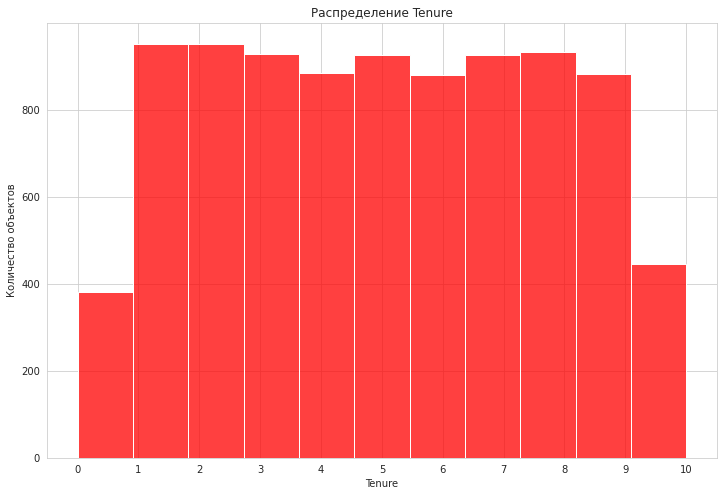

In [6]:
# построение гистограммы распределения данных столбца Tenure
fig, ax = plt.subplots(figsize=(12,8))

sns.histplot(data=data_useful,
             x='Tenure',
             color='red', 
             bins= data_useful['Tenure'].nunique()
            )

ax.set_xticks(range(11))

plt.title('Распределение Tenure');
plt.xlabel('Tenure')
plt.ylabel('Количество объектов')

plt.show()

Нам не удалось установить взаимосвязь между пропусками и данными других столбцов. 

Пропуски встречаются в ~9% данных, и удаление содержащих пропуски объектов приведет к потере существенной части данных.

Поскольку данные с пропусками являются количественными и распределены нормально, заполним пропуски при помощи *IterativeImputer*. Для этого нам сначала потребуется преобразовать категориальные признаки в численные. Мы также предполагаем, что наличие пропусков может являться дополнительной информацией для построения модели, поэтому сначала сохраним информацию о пропусках в отдельный столбец-индикатор:

In [7]:
# создание столбца-индикатора пропусков
data_useful['Tenure_missing'] = data_useful['Tenure'].isna() * 1

# проверка создания столбца-индикатора пропусков
display(data_useful.query('Tenure.isna()').head())
data_useful.query('not Tenure.isna()').head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_missing
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0,1
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0,1
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0,1


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_missing
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0


### Преобразование категориальных признаков в численные

Для преобразования используем технику One-Hot Encoding:

In [8]:
# преобразование категориальных признаков с сохранением результатов в переменную data_useful_ohe
data_useful_ohe = pd.get_dummies(data_useful, drop_first=True)

# проверка преобазования путем вывода на экран первых 5 объектов data_useful_ohe
data_useful_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_missing,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,0


Теперь заполним пропуски:

In [9]:
# заполнение пропусков при помощи IterativeImputer
imputer = IterativeImputer(random_state=12345)
imputed = imputer.fit_transform(data_useful_ohe)
data_useful_ohe_imputed = pd.DataFrame(imputed, columns=data_useful_ohe.columns)

# проверка заполнения пропусков 
data_useful_ohe_imputed['Tenure'].isna().sum()

0

### Создание переменных с признаками и целевым признаком и разделение выборки на обучающую, валидационную и тестовую

При разделении выборки на обучающую, валидационную и тестовую будем использовать соотношение 3/1/1. Cохраним изначальное распределение целевого признака в новых выборках при помощи стратификации. Также для удобства создадим словарь с выборками и их названиями:

In [10]:
# создание переменных features и target с признаками и целевым признаком
features = data_useful_ohe_imputed.drop(columns='Exited')
target = data_useful_ohe_imputed['Exited']

# разделение выборки на обучающую, валидационную и тестовую
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.2, stratify=data_useful_ohe_imputed['Exited'], random_state=37246)
features_train, features_valid, target_train, target_valid = train_test_split(
     features_train_val, target_train_val, test_size=0.25, stratify=target_train_val, random_state=37246)

# создание словаря с выборками и их названиями
subsets_names = ['features_train', 'features_valid',  'features_test', 
                 'target_train', 'target_valid', 'target_test']
subsets = [features_train, features_valid,  features_test, 
           target_train, target_valid, target_test]
subsets_dict = dict(zip(subsets_names, subsets))

# проверка разделения данных на выборки
for subset_name, subset in subsets_dict.items():
    print(subset_name)
    print(subset.shape)
    print()
    
# проверка распределения целевого признака в новых выборках
for subset_name, subset in {k: v for k, v in subsets_dict.items() if k.startswith('target')}.items():
    print(subset_name)
    print(subset.value_counts() / subset.shape)
    print()

features_train
(6000, 12)

features_valid
(2000, 12)

features_test
(2000, 12)

target_train
(6000,)

target_valid
(2000,)

target_test
(2000,)

target_train
0.0    0.796167
1.0    0.203833
Name: Exited, dtype: float64

target_valid
0.0    0.7965
1.0    0.2035
Name: Exited, dtype: float64

target_test
0.0    0.7965
1.0    0.2035
Name: Exited, dtype: float64



### Масштабирование количественных признаков

Для масштабирования будем использовать метод стандартизации данных:

In [11]:
# создание переменной numeric со списком названий столбцов, содержащих количественные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# создание объекта структуры StandardScaler и его настройка на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# преобразование обучающей, валидационной и тестовой выборок функцией transform() 
# и вывод на экран первых 5 объектов каждой выборки 
for subset_name, subset in {k: v for k, v in subsets_dict.items() if k.startswith('features')}.items():
    subset[numeric] = scaler.transform(subset[numeric])
    print(subset_name)
    display(subset.head())
    print('-' * 80)
    print()

features_train


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_missing,Geography_Germany,Geography_Spain,Gender_Male
812,-1.390583,-0.564964,-0.716704,-1.226145,0.810347,1.0,1.0,-0.717470,0.0,0.0,1.0,0.0
9337,-1.907337,0.768135,0.013791,0.411320,-0.902257,1.0,1.0,1.458910,1.0,1.0,0.0,0.0
836,0.449059,-0.184079,-0.716704,-1.226145,0.810347,1.0,1.0,0.822228,0.0,0.0,1.0,0.0
3056,0.356043,1.815570,-1.436089,0.454802,-0.902257,1.0,1.0,0.947201,0.0,0.0,0.0,1.0
4144,0.045991,0.482471,1.081760,0.176909,-0.902257,0.0,1.0,1.547076,0.0,0.0,0.0,1.0


--------------------------------------------------------------------------------

features_valid


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_missing,Geography_Germany,Geography_Spain,Gender_Male
2537,-0.801484,-0.564964,0.007856,0.219463,-0.902257,1.0,0.0,0.656006,1.0,0.0,0.0,0.0
8992,-0.439757,0.101585,1.081760,0.726407,-0.902257,0.0,0.0,-0.674259,0.0,1.0,0.0,0.0
3926,0.655760,-0.945850,0.362374,0.263774,-0.902257,1.0,1.0,-0.527587,0.0,1.0,0.0,1.0
9148,0.490399,-0.184079,1.081760,-1.226145,0.810347,0.0,0.0,0.787228,0.0,0.0,0.0,1.0
853,0.025321,0.387250,-0.006122,-1.226145,0.810347,1.0,1.0,-1.612684,1.0,0.0,0.0,0.0


--------------------------------------------------------------------------------

features_test


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_missing,Geography_Germany,Geography_Spain,Gender_Male
2702,-0.295066,-0.850628,-0.357011,0.504246,-0.902257,0.0,1.0,1.691772,0.0,0.0,0.0,0.0
1587,-0.605118,-0.184079,0.722067,-1.226145,0.810347,1.0,1.0,0.468607,0.0,0.0,0.0,0.0
2137,2.061329,-0.088857,-1.436089,0.488090,0.810347,1.0,0.0,-1.229141,0.0,0.0,0.0,0.0
6689,-0.212386,0.196807,0.722067,0.498351,-0.902257,0.0,1.0,-0.935869,0.0,0.0,1.0,1.0
3970,-1.462929,-0.850628,0.362374,-1.226145,0.810347,1.0,0.0,1.407706,0.0,0.0,0.0,1.0


--------------------------------------------------------------------------------



### Выводы

В ходе подготовки данных мы:
- удалили лишние признаки;
- устранили выявленные пропуски в столбце Tenure;
- преобразоваил категориальные признаки в численные;
- сохранили признаки и целевой признак в отдельные переменные;
- разделили выборку на обучающую, валидационную и тестовую;
- масштабировали количественные признаки.

Теперь мы можем провести исследование баланса классов и создать базовую модель.

## Исследование баланса классов

Исследуем баланс классов. Для этого:
- изучим долю каждого класса;
- обучим базовую модель на несбалансированных данных и изучим ее метрики. 

In [12]:
# подсчет и вывод на экран доли каждого класса
data_useful_ohe_imputed['Exited'].value_counts()/data.shape[0]

0.0    0.7963
1.0    0.2037
Name: Exited, dtype: float64

Мы видим, что данные не сбалансированы: соотношение классов составляет ~80/20.

В качестве базовой используем модель логистической регрессии. Также для удобства создадим функцию *show_metrics*, которая будет принимать на вход модель, тип выборки (обучающая, валидационная и тестовая) и порог и отображать значения *F1*-меры, точности, полноты и *AUC-ROC*:

In [13]:
def show_metrics(model, subset='train', threshold=0.5):
    '''
    Функция на основе модели, типа выборки и порога отображает значения F1-меры, точности, полноты и AUC-ROC.
    
    Входные параметры:
    - model - модель, чьи метрики необходимо отобразить
    - subset - тип выборки (обучающая, тестовая), на которой необходимо расчитать метрики модели, по умолчанию обучающая
    - threshold - порог, по умолчанию 0,5
    '''
    
    subsets_pairs_dict = {
        'train': [features_train, target_train],
        'valid': [features_valid, target_valid],
        'test': [features_test, target_test]
    }
        
    predicted = model.predict_proba(subsets_pairs_dict[subset][0])[:, 1]  > threshold    
    
    precision = precision_score(subsets_pairs_dict[subset][1], predicted)
    recall = recall_score(subsets_pairs_dict[subset][1], predicted)
    f1 = f1_score(subsets_pairs_dict[subset][1], predicted)
    auc_roc = roc_auc_score(subsets_pairs_dict[subset][1], predicted)
    
    print("F1:", f1)
    print("precision:", precision)
    print("recall:", recall)
    print("AUC-ROC:", auc_roc)

In [14]:
# создание базовой модели
model = LogisticRegression(solver='liblinear', random_state=12345) 

# обучение базовой модели
model.fit(features_train, target_train)

# вывод метрик базовой модели на валидационной выборке с использованием функции show_metrics
show_metrics(model, 'valid')

F1: 0.326241134751773
precision: 0.5859872611464968
recall: 0.22604422604422605
AUC-ROC: 0.5926203553322198


### Выводы

По результатам исследования баланса классов мы пришли к следующим выводам:

- данные не сбалансированы: соотношение классов составляет ~80/20;
- низкие значения *F1*-меры и *AUC-ROC* базовой модели на несбалансированных данных (0,33 и 0,59 соответственно) обусловлены низким значением полноты (0,23).

На следующем этапе улучшим качество модели.

## Улучшение качества модели

Наша работа по улучшению качества модели будет вестить в трех направлениях:

1. устранение дисбаланса классов;
2. подбор оптимальных алгоритма и гиперпараметров модели;
3. подбор порога.

### Устранение дисбаланса классов

Протестируем 4 стратегии устранения дисбаланса классов:

1. автоматическое взвешивание классов;
2. ручное взвешивание классов;
3. увеличение выборки; 
4. уменьшение выборки.

#### Автоматическое взвешивание классов

Для автоматического взвешивания классов при создании модели укажем значение параметра *class_weight* равным `balanced`:

In [15]:
# создание модели
model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced') 

# обучение модели
model.fit(features_train, target_train)

# вывод метрик базовой модели на обучающей выборке с автоматическим взвешиванием классов
# с использованием функции show_metrics
show_metrics(model, 'valid')

F1: 0.4941176470588235
precision: 0.37547892720306514
recall: 0.7223587223587223
AUC-ROC: 0.7076953687123179


Применение автоматического взвешивания классов дало более высокие (по сравнению с несблансированными данными) значения *F1*-меры (0,49) и *AUC-ROC* (0,71) за счет увеличения полноты (с ~0,23 до ~0,72), но при этом значение точности существенно снизилось (с ~0,59 до ~0,38).

#### Ручное взвешивание классов

При помощи цикла самостоятельно подберем такие веса классов, которые дают лучшее значение *F1*-меры:

In [16]:
%%time

# создание переменных best_class_weights, best_class_weights_model и best_class_weights_model_f1_score
best_class_weights = None
best_class_weights_model = None
best_class_weights_f1_score = 0

# создание цикла, который:
# - поочередно присваивает классам веса от 1 до 99,99 (c шагом 0,1)
# - создает и обучает базовую модель с заданными весами классов
# - сохраняет в переменные best_class_weights, best_class_weights_model и best_class_weights_f1_score
# значения модели, показавшей лучшее значение F-1 меры на валидационной выборке
for i in np.arange(1, 100, 0.1):
    class_weights = {0: i, 1: 100-i}
    model = LogisticRegression(solver='liblinear', random_state=12345, class_weight=class_weights) 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    class_weights_f1_score = f1_score(target_valid, predicted_valid)
    if class_weights_f1_score > best_class_weights_f1_score:
        best_class_weights = class_weights
        best_class_weights_model = model
        best_class_weights_f1_score = class_weights_f1_score

# вывод на экран значений весов классов, давших лучшее значение F-1 меры
print(best_class_weights.items())
print()

# вывод метрик базовой модели на валидационной выборке с лучшим результатом взвешивания классов
# с использованием функции show_metrics
show_metrics(best_class_weights_model, 'valid')

dict_items([(0, 27.700000000000024), (1, 72.29999999999998)])

F1: 0.5229455709711847
precision: 0.46226415094339623
recall: 0.601965601965602
AUC-ROC: 0.7115289403424998
CPU times: user 58.5 s, sys: 57.7 s, total: 1min 56s
Wall time: 1min 59s


Применение ручного взвешивания классов позволило дополнительно повысить значения *F1*-меры (до 0,52) и *AUC-ROC* за счет улучшения точности.

#### Увеличение выборки

Проведем upsampling тестовой выборки и используем результат для обучения базовой модели:

In [17]:
# разделение обучающей выборки на отрицательные и положительные объекты с сохранением
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

# расчет отношения количества отрицательных объектов к количеству положительных объектов
zeroes_to_ones_ratio = int(features_zeros.shape[0]/features_ones.shape[0])

# копирование положительных объектов и создание новой обучающей выборки
features_upsampled = pd.concat([features_zeros] + [features_ones] * zeroes_to_ones_ratio)
target_upsampled = pd.concat([target_zeros] + [target_ones] * zeroes_to_ones_ratio)
    
# перемешивание новой обучающей выборки
features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)

# создание модели
model = LogisticRegression(solver='liblinear', random_state=12345)

# обучение модели на новой обучающей выборке
model.fit(features_upsampled, target_upsampled)

# вывод метрик модели на валидационной выборке 
show_metrics(model, 'valid')

F1: 0.5073746312684365
precision: 0.42295081967213116
recall: 0.6339066339066339
AUC-ROC: 0.7064699522326641


Применение увеличения выборки дало более низкие (по сравнению с ручным взвешиванием) значения *F1*-меры (0,51 против 0,52) и *AUC-ROC* (0,706 против 0,712).

#### Уменьшение выборки

In [18]:
# расчет отношения количества положительных объектов к количеству отрицательных объектов
ones_to_zeroes_ratio = features_ones.shape[0]/features_zeros.shape[0]

# отбрасывание части отрицательных объектов и создание новой обучающей выборки
features_downsampled = pd.concat(
    [features_zeros.sample(frac=ones_to_zeroes_ratio, random_state=12345)] + [features_ones])
target_downsampled = pd.concat(
    [target_zeros.sample(frac=ones_to_zeroes_ratio, random_state=12345)] + [target_ones])

# перемешивание новой обучающей выборки
features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)

# создание модели
model = LogisticRegression(solver='liblinear', random_state=12345)

# обучение модели
model.fit(features_downsampled, target_downsampled)

# вывод метрик модели на валидационной выборке 
show_metrics(model, 'valid')

F1: 0.48837209302325574
precision: 0.36888331242158096
recall: 0.7223587223587223
AUC-ROC: 0.7033011439791101


Применение уменьшения выборки также дало самыеые низкие (по сравнению с остальными стратегиями) значения *F1*-меры (0,488) и *AUC-ROC* (0,703).

#### Выбор стратегии устранения дисбаланса классов

Лучшие значения *F1*-меры (0,52) и *AUC-ROC* (0,71) показало ручное взвешивание классов. Применим данную стратегию при выборе оптимальных алгоритма и гиперпараметров модели

### Подбор оптимальных алгоритма и гиперпараметров модели

Исследуем модели, использующие следующие алгоритмы:

1. решающее дерево;
2. случайный лес; и
3. логистическая регрессия.

Для каждого алгоритма:

- создадим модель (значение параметра *class_weight* укажем равным `best_class_weights`);
- обучим модель на обучающей выборке;
- при помощи *GridSearchCV* оптимизируем значения гиперпараметров, чтобы получить лучшее значение *F1*-меры;
- оптимизацию гиперпараметров будем проводить на обучающей выборке

#### Исследование модели решающего дерева

Проведем исследование модели решающего дерева. Для достижения лучшего значения *F1-меры* будем изменять гиперпараметр `max_depth` (от 1 до 10):

In [19]:
# создание словаря c гиперпараметром и диапазоном его значений, которые будут оптимизироваться
param_dict = {'max_depth': range(1,11)}

# создание модели решающего дерева
model = DecisionTreeClassifier(random_state=12345, class_weight=best_class_weights)

# оптимизация гиперпараметров
grid = GridSearchCV(model, param_grid=param_dict, scoring='f1', cv=5, refit=True)
grid.fit(features_train, target_train)

# создание переменных с лучшей моделью и лучшим средним значением F1-меры
best_tree_model = grid.best_estimator_
best_tree_model_f1_score = grid.best_score_

# вывод на экран значений гиперпараметров и F1-меры лучшей модели
print('Значение F1-меры лучшей модели решающего дерева:', best_tree_model_f1_score)
print('Гиперпараметры лучшей модели решающего дерева:', grid.best_params_)

Значение F1-меры лучшей модели решающего дерева: 0.5828105793248971
Гиперпараметры лучшей модели решающего дерева: {'max_depth': 5}


#### Исследование модели случайного леса

Проведем исследование модели случайного леса. Для достижения лучшего значения *F1-меры* будем изменять гиперпараметры: 
- `max_depth` (от 1 до 15 с шагом 2);
- `n_estimators` (от 60 до 180 с шагом 20).

In [21]:
%%time

# создание словаря с гиперпараметрами и диапазоном их значений, которые будут оптимизироваться
param_dict = {
    'max_depth': range(1,16,2),
    'n_estimators': range(60,141,20)
}

# создание модели случайного леса
model = RandomForestClassifier(random_state=12345, class_weight=best_class_weights)

# оптимизация гиперпараметров
grid = GridSearchCV(model, param_grid=param_dict, scoring='roc_auc', cv=5, refit=True)
grid.fit(features_train, target_train)

# создание переменных с лучшей моделью и лучшим средним значением F1-меры
best_forest_model = grid.best_estimator_
best_forest_model_f1_score = grid.best_score_

# вывод на экран значений гиперпараметров и F1-меры лучшей модели
print('Значение F1-меры лучшей модели случайного леса:', best_forest_model_f1_score)
print('Гиперпараметры лучшей модели случайного леса:', grid.best_params_)

Значение F1-меры лучшей модели случайного леса: 0.8586266706812798
Гиперпараметры лучшей модели случайного леса: {'max_depth': 9, 'n_estimators': 120}
CPU times: user 1min 22s, sys: 838 ms, total: 1min 23s
Wall time: 1min 23s


#### Исследование модели логистической регрессии

In [22]:
# создание словаря с гиперпараметрами и диапазоном их значений, которые будут оптимизироваться
param_dict = {
    'penalty' : ['l1','l2', 'none'], 
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

# создание модели логистической регрессии
model = LogisticRegression(random_state=12345, max_iter=10000, class_weight=best_class_weights) 

# оптимизация гиперпараметров
grid = GridSearchCV(model, param_grid=param_dict, scoring='f1', cv=5, refit=True)
grid.fit(features_train, target_train)

# создание переменных с лучшей моделью и лучшим accuracy
best_logreg_model = grid.best_estimator_
best_logreg_model_f1_score = grid.best_score_

# вывод на экран значений гиперпараметров и F1-меры лучшей модели
print('Значение F1-меры лучшей модели логистической регрессии:', best_logreg_model_f1_score)
print('Гиперпараметры лучшей модели логистической регрессии:', grid.best_params_)

Значение F1-меры лучшей модели логистической регрессии: 0.4833480198660691
Гиперпараметры лучшей модели логистической регрессии: {'penalty': 'l1', 'solver': 'liblinear'}


#### Выбор лучшей модели  и гиперпараметров

In [23]:
# создание списков с лучшими моделями каждого алгоритма и значениями их F1-меры
best_models = [best_tree_model, best_forest_model, best_logreg_model]
best_models_f1_scores = [best_tree_model_f1_score, best_forest_model_f1_score, 
                          best_logreg_model_f1_score]

# создание переменных для сохранения лучшей модели, ее алгоритма и значения ее F1-меры
best_overall_model = None
best_overall_model_algorithm = None
best_overall_model_f1_score = 0

# создание цикла, который сравнит значения F1-меры лучших моделей и присвоит вышеуказанным переменным значения 
# модели с наибольшим значением F1-меры
for model, score in zip(best_models, best_models_f1_scores):
    if score > best_overall_model_f1_score:
        best_overall_model = model
        best_overall_model_algorithm = type(model).__name__.removesuffix('Classifier').lower()
        best_overall_model_f1_score = score

# вывод на алгоритма и F1-меры лучшей модели
print('Алгоритм лучшей модели:', best_overall_model_algorithm)
print('F1-мера лучшей модели:', best_overall_model_f1_score)

Алгоритм лучшей модели: randomforest
F1-мера лучшей модели: 0.8586266706812798


По итогам сравнения лучших моделей на основе алгоритмов решающего дерева, случайного леса и логистической регрессии лучшей моделью стала модель на основе алгоритма случайного леса с гиперпараметрами *max_depth* и *n_estimators*, равными 7 и 120 соответственно. Она показала среднее значение *F1*-меры, равное ~0,62.

Используем ее для изменения порога и финального тестирования.

### Подбор порога

При помощи цикла подберем порог, дающий лучшее значение *F1*-меры лучшей модели на валидационной выборке:

In [24]:
best_overall_model = best_forest_model

In [25]:
# создание переменных best_threshold и best_threshold_f1_score
best_threshold = 0
best_threshold_f1_score = 0

# создание цикла, который:
# - поочередно перебирает элементы диапазона порога от 1 до 99,99 (c шагом 0,1)
# - рассчитвает F1-меру лучшей модели с таким порогом на валидационной выборке
# - сохраняет в переменные best_threshold и best_threshold_f1_score
# значение порога, показавшее лучшее значение F-1 меры на валидационной выборке, и лучшее значение F-1 меры
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = best_overall_model.predict_proba(features_valid)[:, 1] > threshold
    threshold_f1_score = f1_score(target_valid, predicted_valid)
    if threshold_f1_score > best_threshold_f1_score:
        best_threshold = threshold
        best_threshold_f1_score = threshold_f1_score

# вывод на экран значения порога, при котором лучшая модель показала наибольшее значение F1- меры
# и метрик лучшей модели с таким порогом
print('Лучший порог на валидационной выборке:', best_threshold)
show_metrics(best_overall_model, 'valid', best_threshold)

Лучший порог на валидационной выборке: 0.42
F1: 0.6234906695938529
precision: 0.5634920634920635
recall: 0.6977886977886978
AUC-ROC: 0.7798422459439409


Лучшеее значение *F1*-меры на валидационной выборке показал порог 0,42. Используем его для финального тестирования.

### Выводы

В результате улучшения качества модели нам удалось повысить значение *F1*-меры на валидационной выборке до 0,62 путем:
- устранения дисбаланса классов за счет стратегии ручного взвешивания;
- подбора алгоритма и гиперпараметров модели (лучший результат показала модель на основе алгоритма случайного леса с гиперпараметрами max_depth и n_estimators, равными 7 и 120 соответственно);
- подбора порога (лучший результат показал порог 0,42).

## Финальное тестирование лучшей модели

Проведем финальное тестирование лучшей модели на тестовой выборке:

In [26]:
# вывод на экран метрик лучшей модели с использованием лучшего порога на тестовой выборке
show_metrics(best_overall_model, 'test', best_threshold)

F1: 0.6269005847953216
precision: 0.5982142857142857
recall: 0.6584766584766585
AUC-ROC: 0.7727411540970863


### Выводы

Лучшая модель показала на тестовой выборке значения *F1*-меры и *AUC-ROC*, равные 0,63 и 0,77 соответственно, что отвечает требованиям ТЗ.

## Общие выводы

На основе предоставленных данных о поведении клиентов банка мы построили модель, которая будет прогнозировать, уйдет ли клиент из банка в ближайшее время.

Работа состояла из пяти этапов:

1. загрузка и изучение данных;
2. подготовка данных;
3. исследование баланса классов; 
4. улучшение качества модели;
5. финальное тестирование лучшей модели.


**1. Загрузка и изучение данных**

На данном этапе мы загрузили и изучили предоставленные данные. По итогам их изучения мы установили:

- в наборе данных 10 000 объектов;
- каждый объект в наборе данных — это информация о поведении одного клиента;
- по каждому объекту доступно 15 признаков (включая целевой);
- признаки *RowNumber*, *CustomerId* и *Surname* не требуются для построения модели;
- аномалии не выявлены;
- в столбце с признаком *Tenure* есть пропуски (9,09% данных).

**2. Подготовка данных**

В ходе подготовки данных мы:
- удалили лишние признаки;
- устранили выявленные пропуски в столбце Tenure;
- преобразоваил категориальные признаки в численные;
- сохранили признаки и целевой признак в отдельные переменные;
- разделили выборку на обучающую, валидационную и тестовую;
- масштабировали количественные признаки.

**3. Исследование баланса классов**

На данном этапе мы:

- изучили долю каждого класса;
- обучили базовую модель на несбалансированных данных и изучили ее метрики.

По результатам исследования баланса классов мы пришли к следующим выводам:

- данные не сбалансированы: соотношение классов составляет ~80/20;
- низкие значения *F1*-меры и *AUC-ROC* базовой модели на несбалансированных данных (0,33 и 0,59 соответственно) обусловлены низким значением полноты (0,23).

**4. Улучшение качества модели**

Наша работа по улучшению качества модели включала три направления:

1. устранение дисбаланса классов;
2. подбор оптимальных алгоритма и гиперпараметров модели;
3. подбор порога.

В результате улучшения качества модели нам удалось повысить значение *F1*-меры на валидационной выборке до 0,62 путем:
- устранения дисбаланса классов за счет стратегии ручного взвешивания;
- подбора алгоритма и гиперпараметров модели (лучший результат показала модель на основе алгоритма случайного леса с гиперпараметрами max_depth и n_estimators, равными 7 и 120 соответственно);
- подбора порога (лучший результат показал порог 0,42).

**5. Финальное тестирование лучшей модели**

На данном этапе мы протестировали лучшую модель на тестовой выборке.
Лучшая модель показала на тестовой выборке значения *F1*-меры и *AUC-ROC*, равные 0,63 и 0,77 соответственно, что отвечает требованиям ТЗ.